In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import glob, os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from bokeh.plotting import figure, show
from bokeh.palettes import Spectral4
# from bkcharts import TimeSeries, output_file, show
from bokeh.io import output_notebook
output_notebook()

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

Using TensorFlow backend.


Loading BokehJS ...

# Data Preparation

Data yang digunakan untuk pengujian ini dataset delay penerbangan kota New York pada bulan Januari 2019. Data ini awalnya terdapat 16 atribut. **CRS** berarti waktu yang sudah terjadwal, sedangkan **ACTUAL** berarti waktu yang sebenarnya terjadi. *Departure delay* berupa anga dalam satuan menit, bila data > 0 maka terjadi *delay*, bila data = 0 berarti keberangkatan tepat waktu, sedangkan data < 0 (atau negatif) berarti keberangkatan lebih awal.

In [2]:
data = pd.concat(map(pd.read_csv, glob.glob(os.path.join('dataset/2years', '*.csv'))))

In [3]:
data.reset_index(inplace=True, drop=True)
data = data.drop(['Unnamed: 18'], axis=1)
data.shape

(1450183, 18)

### Convert FL_DATE to datetime

In [4]:
data['FL_DATE'] = pd.to_datetime(data.FL_DATE)
# data['CRS_DEP_TIME'] = pd.to_datetime(data['CRS_DEP_TIME'], format='%H%M').dt.time
# data['FL_DATE'] +=  pd.to_timedelta(data.CRS_DEP_TIME.astype(str), unit='s')

### Split *CRS departure time* during 00:00 - 00:59

In [5]:
dropindex = []
for i in data.itertuples():
    x = len(str(i.CRS_DEP_TIME))
    if x == 1 or x == 2:
        dropindex.append(i.Index)
data1 = data.loc[dropindex]
data.drop(data.index[dropindex], inplace=True)
data1.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
489,2018-01-01,12892,"Los Angeles, CA",12478,"New York, NY",40,55.0,15.0,856,846.0,-10.0,0.0,0.0,316.0,291.0,271.0,1.0,2475.0
2149,2018-01-02,12892,"Los Angeles, CA",12478,"New York, NY",40,37.0,-3.0,856,905.0,9.0,0.0,0.0,316.0,328.0,296.0,1.0,2475.0
2742,2018-01-02,11057,"Charlotte, NC",14576,"Rochester, NY",10,10.0,0.0,153,147.0,-6.0,0.0,0.0,103.0,97.0,77.0,1.0,573.0
2964,2018-01-02,11298,"Dallas/Fort Worth, TX",12478,"New York, NY",5,5.0,0.0,429,402.0,-27.0,0.0,0.0,204.0,177.0,160.0,1.0,1391.0
3497,2018-01-02,11292,"Denver, CO",12953,"New York, NY",53,119.0,26.0,637,646.0,9.0,0.0,0.0,224.0,207.0,191.0,1.0,1620.0


In [6]:
data.loc[data['CRS_DEP_TIME'] == 9]

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE


## Convert *CRS departure time* from int to time

In [7]:
data['CRS_DEP_TIME'] = pd.to_datetime(data['CRS_DEP_TIME'], format='%H%M').dt.time
data1['CRS_DEP_TIME'] = pd.to_datetime(data1['CRS_DEP_TIME'], format='%M').dt.time
# data2['CRS_DEP_TIME'] = pd.to_datetime(data2['CRS_DEP_TIME'], format='%M').dt.time

### Merge *CRS departure time*

In [8]:
data = data.append(data1)
data.sort_index(inplace=True)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
0,2018-01-01,13930,"Chicago, IL",10257,"Albany, NY",06:30:00,650.0,20.0,922,936.0,14.0,0.0,0.0,112.0,106.0,83.0,1.0,723.0
1,2018-01-01,10257,"Albany, NY",13930,"Chicago, IL",10:04:00,1022.0,18.0,1134,1124.0,-10.0,0.0,0.0,150.0,122.0,106.0,1.0,723.0
2,2018-01-01,10257,"Albany, NY",13930,"Chicago, IL",06:15:00,748.0,93.0,746,850.0,64.0,0.0,0.0,151.0,122.0,108.0,1.0,723.0
3,2018-01-01,12953,"New York, NY",12266,"Houston, TX",07:52:00,741.0,-11.0,1101,1052.0,-9.0,0.0,0.0,249.0,251.0,228.0,1.0,1416.0
4,2018-01-01,12266,"Houston, TX",12953,"New York, NY",16:20:00,1618.0,-2.0,2046,2045.0,-1.0,0.0,0.0,206.0,207.0,180.0,1.0,1416.0


In [9]:
data['FL_DATE'] +=  pd.to_timedelta(data.CRS_DEP_TIME.astype(str), unit='s')
data = data.sort_values(by='FL_DATE',ascending=True)
data.reset_index(inplace=True, drop=True)
data.head()
data.loc[data['DEP_TIME'] == 7]

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
10366,2018-01-06 23:55:00,12892,"Los Angeles, CA",12478,"New York, NY",23:55:00,7.0,12.0,815,902.0,47.0,0.0,0.0,320.0,355.0,284.0,1.0,2475.0
12060,2018-01-07 19:51:00,12478,"New York, NY",11697,"Fort Lauderdale, FL",19:51:00,7.0,256.0,2325,303.0,218.0,0.0,0.0,214.0,176.0,152.0,1.0,1069.0
14400,2018-01-08 23:58:00,10140,"Albuquerque, NM",12478,"New York, NY",23:58:00,7.0,9.0,551,609.0,18.0,0.0,0.0,233.0,242.0,226.0,1.0,1826.0
22746,2018-01-12 21:58:00,11433,"Detroit, MI",10577,"Binghamton, NY",21:58:00,7.0,129.0,2332,131.0,119.0,0.0,0.0,94.0,84.0,66.0,1.0,378.0
24138,2018-01-13 23:59:00,12478,"New York, NY",14843,"San Juan, PR",23:59:00,7.0,8.0,443,451.0,8.0,0.0,0.0,224.0,224.0,200.0,1.0,1598.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361937,2019-10-17 22:46:00,12953,"New York, NY",11292,"Denver, CO",22:46:00,7.0,81.0,101,200.0,59.0,0.0,0.0,255.0,233.0,212.0,1.0,1620.0
1393154,2019-11-02 23:55:00,14771,"San Francisco, CA",12478,"New York, NY",23:55:00,7.0,12.0,735,819.0,44.0,0.0,0.0,280.0,312.0,226.0,1.0,2586.0
1420757,2019-11-15 23:59:00,14869,"Salt Lake City, UT",12478,"New York, NY",23:59:00,7.0,8.0,609,614.0,5.0,0.0,0.0,250.0,247.0,229.0,1.0,1990.0
1426377,2019-11-18 19:59:00,12953,"New York, NY",11193,"Cincinnati, OH",19:59:00,7.0,248.0,2220,155.0,215.0,0.0,0.0,141.0,108.0,90.0,1.0,585.0


In [10]:
data.head(10)
data.shape[0]

1450183

In [11]:
duplicated = data[data.duplicated(subset='FL_DATE', keep='first')]
duplicated.shape[0]

993682

In [12]:
data = data.drop_duplicates(subset='FL_DATE', keep='first')
data.reset_index(inplace=True, drop=True)

In [13]:
data.shape[0]
# data.head(10)

456501

### Check NaN

In [14]:
data.isna().sum()

FL_DATE                    0
ORIGIN_AIRPORT_ID          0
ORIGIN_CITY_NAME           0
DEST_AIRPORT_ID            0
DEST_CITY_NAME             0
CRS_DEP_TIME               0
DEP_TIME               12505
DEP_DELAY              13171
CRS_ARR_TIME               0
ARR_TIME               13395
ARR_DELAY              15049
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           1
ACTUAL_ELAPSED_TIME    14729
AIR_TIME               14729
FLIGHTS                    0
DISTANCE                   0
dtype: int64

### Drop NaN and check again

In [15]:
data = data.dropna(subset=['DEP_DELAY', 'ARR_DELAY'])
data.isna().sum()

FL_DATE                0
ORIGIN_AIRPORT_ID      0
ORIGIN_CITY_NAME       0
DEST_AIRPORT_ID        0
DEST_CITY_NAME         0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
FLIGHTS                0
DISTANCE               0
dtype: int64

### Calculate *Departure time* based on *Departure delay*

Because there is some error with value in DEP_DELAY column, so we need to calculate its value to make sure the value is right.

In [16]:
# Example, the value of departure delay is only 1 digit (7) 
# because int dtype cannot display 0 before integer. 
data.loc[1223]

FL_DATE                2018-01-03 10:35:00
ORIGIN_AIRPORT_ID                    10397
ORIGIN_CITY_NAME               Atlanta, GA
DEST_AIRPORT_ID                      12478
DEST_CITY_NAME                New York, NY
CRS_DEP_TIME                      10:35:00
DEP_TIME                              1039
DEP_DELAY                                4
CRS_ARR_TIME                          1250
ARR_TIME                              1238
ARR_DELAY                              -12
CANCELLED                                0
DIVERTED                                 0
CRS_ELAPSED_TIME                       135
ACTUAL_ELAPSED_TIME                    119
AIR_TIME                                96
FLIGHTS                                  1
DISTANCE                               760
Name: 1223, dtype: object

In [17]:
for row in data.itertuples():
    i = row.CRS_DEP_TIME
    j = row.DEP_DELAY
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    if j<0:
        d = dt.timedelta(minutes=abs(j))
        k = c - d
    else:
        d = dt.timedelta(minutes=j)
        k = c + d
    if row.DEP_TIME != k:
        data.at[row.Index, 'DEP_TIME'] = k

In [18]:
# data.loc[1609]
data.loc[1223]

FL_DATE                2018-01-03 10:35:00
ORIGIN_AIRPORT_ID                    10397
ORIGIN_CITY_NAME               Atlanta, GA
DEST_AIRPORT_ID                      12478
DEST_CITY_NAME                New York, NY
CRS_DEP_TIME                      10:35:00
DEP_TIME                          10:39:00
DEP_DELAY                                4
CRS_ARR_TIME                          1250
ARR_TIME                              1238
ARR_DELAY                              -12
CANCELLED                                0
DIVERTED                                 0
CRS_ELAPSED_TIME                       135
ACTUAL_ELAPSED_TIME                    119
AIR_TIME                                96
FLIGHTS                                  1
DISTANCE                               760
Name: 1223, dtype: object

### Delete day on *Departure time*

In [19]:
to_str = []
for row in data.itertuples():
    i = len(str(row.DEP_TIME))
    if i != 8:
        to_str.append(row.Index)

In [20]:
data3 = data.loc[set(data.index) - set(to_str)]
data4 = data.loc[to_str]

data3['DEP_TIME'] = pd.to_datetime(data3['DEP_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data4['DEP_TIME'] = pd.to_datetime(data4['DEP_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [21]:
# data4.loc[1609]

### Merge

In [22]:
data = data3.append(data4)
data.head(3)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
16,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,900,1428.0,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0
29,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,759,1146.0,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0
44,2018-01-01 07:10:00,12478,"New York, NY",12892,"Los Angeles, CA",07:10:00,10:21:00,191.0,1030,1339.0,189.0,0.0,0.0,380.0,378.0,347.0,1.0,2475.0


### Calculate CRS Arrival time based on CRS Elapsed time

Because there is some error with value in CRS_ARR_TIME column, so we need to calculate its value to make sure the value is right.

In [23]:
for row in data.itertuples():
    i = row.CRS_DEP_TIME
    j = row.CRS_ELAPSED_TIME
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    d = dt.timedelta(minutes=j)
    k = c + d
    if row.CRS_ARR_TIME != k:
        data.at[row.Index, 'CRS_ARR_TIME'] = k

In [24]:
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
16,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,8:00:00,1428.0,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0
29,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,8:59:00,1146.0,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0
44,2018-01-01 07:10:00,12478,"New York, NY",12892,"Los Angeles, CA",07:10:00,10:21:00,191.0,13:30:00,1339.0,189.0,0.0,0.0,380.0,378.0,347.0,1.0,2475.0
77,2018-01-01 08:20:00,13930,"Chicago, IL",15096,"Syracuse, NY",08:20:00,10:44:00,144.0,9:58:00,1317.0,139.0,0.0,0.0,98.0,93.0,83.0,1.0,607.0
84,2018-01-01 08:35:00,13232,"Chicago, IL",12953,"New York, NY",08:35:00,12:14:00,219.0,10:40:00,1536.0,236.0,0.0,0.0,125.0,142.0,91.0,1.0,725.0


In [25]:
to_str = []
for row in data.itertuples():
    i = len(str(row.CRS_ARR_TIME))
    if i != 8:
        to_str.append(row.Index)

In [26]:
data6 = data.loc[set(data.index) - set(to_str)]
data7 = data.loc[to_str]

data6['CRS_ARR_TIME'] = pd.to_datetime(data6['CRS_ARR_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data7['CRS_ARR_TIME'] = pd.to_datetime(data7['CRS_ARR_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [27]:
data = data6.append(data7)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
18,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,953.0,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0
35,2018-01-01 06:42:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:42:00,06:54:00,12.0,12:25:00,1008.0,-17.0,0.0,0.0,343.0,314.0,290.0,1.0,1990.0
38,2018-01-01 06:50:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",06:50:00,07:46:00,56.0,11:06:00,1048.0,42.0,0.0,0.0,256.0,242.0,215.0,1.0,1389.0
43,2018-01-01 07:05:00,12478,"New York, NY",13487,"Minneapolis, MN",07:05:00,07:11:00,6.0,10:36:00,907.0,-29.0,0.0,0.0,211.0,176.0,148.0,1.0,1029.0
44,2018-01-01 07:10:00,12478,"New York, NY",12892,"Los Angeles, CA",07:10:00,10:21:00,191.0,13:30:00,1339.0,189.0,0.0,0.0,380.0,378.0,347.0,1.0,2475.0


### Calculate Arrival time based on Arrival delay

Because there is some error with value in ARR_TIME column, so we need to calculate its value to make sure the value is right.

In [28]:
for row in data.itertuples():
    i = row.CRS_ARR_TIME
    j = row.ARR_DELAY
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    if j<0:
        d = dt.timedelta(minutes=abs(j))
        k = c - d
    else:
        d = dt.timedelta(minutes=j)
        k = c + d
    if row.ARR_TIME != k:
        data.at[row.Index, 'ARR_TIME'] = k

In [29]:
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
18,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0
35,2018-01-01 06:42:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:42:00,06:54:00,12.0,12:25:00,12:08:00,-17.0,0.0,0.0,343.0,314.0,290.0,1.0,1990.0
38,2018-01-01 06:50:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",06:50:00,07:46:00,56.0,11:06:00,11:48:00,42.0,0.0,0.0,256.0,242.0,215.0,1.0,1389.0
43,2018-01-01 07:05:00,12478,"New York, NY",13487,"Minneapolis, MN",07:05:00,07:11:00,6.0,10:36:00,10:07:00,-29.0,0.0,0.0,211.0,176.0,148.0,1.0,1029.0
44,2018-01-01 07:10:00,12478,"New York, NY",12892,"Los Angeles, CA",07:10:00,10:21:00,191.0,13:30:00,16:39:00,189.0,0.0,0.0,380.0,378.0,347.0,1.0,2475.0


In [30]:
to_str = []
for row in data.itertuples():
    i = len(str(row.ARR_TIME))
    if i != 8:
        to_str.append(row.Index)

In [31]:
data8 = data.loc[set(data.index) - set(to_str)]
data9 = data.loc[to_str]

data8['ARR_TIME'] = pd.to_datetime(data8['ARR_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data9['ARR_TIME'] = pd.to_datetime(data9['ARR_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [32]:
data = data8.append(data9)
data.reset_index(inplace=True, drop=True)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
0,2018-01-01 05:52:00,14254,"Ponce, PR",12478,"New York, NY",05:52:00,05:48:00,-4.0,09:59:00,10:11:00,12.0,0.0,0.0,247.0,263.0,230.0,1.0,1617.0
1,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,08:00:00,13:28:00,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0
2,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0
3,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,08:59:00,12:46:00,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0
4,2018-01-01 06:24:00,12478,"New York, NY",13495,"New Orleans, LA",06:24:00,06:18:00,-6.0,09:46:00,10:11:00,25.0,0.0,0.0,202.0,233.0,193.0,1.0,1182.0


### Working Day or not

In [33]:
data["DAY_TYPE"] = data.FL_DATE.apply(lambda x: 1 if x.dayofweek > 5 else 0)
data.head(3)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE
0,2018-01-01 05:52:00,14254,"Ponce, PR",12478,"New York, NY",05:52:00,05:48:00,-4.0,09:59:00,10:11:00,12.0,0.0,0.0,247.0,263.0,230.0,1.0,1617.0,0
1,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,08:00:00,13:28:00,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0,0
2,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0,0


### Finding Federal Holidays

In [34]:
cal = calendar()
holidays = cal.holidays(start = data.FL_DATE.min(), end = data.FL_DATE.max())
data["IS_HOLIDAY"] = data.FL_DATE.isin(holidays)
data

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY
0,2018-01-01 05:52:00,14254,"Ponce, PR",12478,"New York, NY",05:52:00,05:48:00,-4.0,09:59:00,10:11:00,12.0,0.0,0.0,247.0,263.0,230.0,1.0,1617.0,0,False
1,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,08:00:00,13:28:00,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0,0,False
2,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0,0,False
3,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,08:59:00,12:46:00,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0,0,False
4,2018-01-01 06:24:00,12478,"New York, NY",13495,"New Orleans, LA",06:24:00,06:18:00,-6.0,09:46:00,10:11:00,25.0,0.0,0.0,202.0,233.0,193.0,1.0,1182.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440817,2019-11-30 23:46:00,14107,"Phoenix, AZ",12478,"New York, NY",23:46:00,00:28:00,42.0,04:16:00,04:29:00,13.0,0.0,0.0,270.0,241.0,223.0,1.0,2153.0,0,False
440818,2019-11-30 23:49:00,14869,"Salt Lake City, UT",12478,"New York, NY",23:49:00,00:09:00,20.0,03:59:00,04:24:00,25.0,0.0,0.0,250.0,255.0,234.0,1.0,1990.0,0,False
440819,2019-11-30 23:52:00,13796,"Oakland, CA",12478,"New York, NY",23:52:00,00:02:00,10.0,05:11:00,05:22:00,11.0,0.0,0.0,319.0,320.0,285.0,1.0,2576.0,0,False
440820,2019-11-30 23:55:00,12892,"Los Angeles, CA",12478,"New York, NY",23:55:00,00:15:00,20.0,05:17:00,05:31:00,14.0,0.0,0.0,322.0,316.0,267.0,1.0,2475.0,0,False


### Departure from NY or Arrival to NY

In [35]:
data['DEP_FROM_NY'] = data.ORIGIN_CITY_NAME.apply(lambda x: 1 if x[-2:] == 'NY' else 0)
data.head(10)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY
0,2018-01-01 05:52:00,14254,"Ponce, PR",12478,"New York, NY",05:52:00,05:48:00,-4.0,09:59:00,10:11:00,12.0,0.0,0.0,247.0,263.0,230.0,1.0,1617.0,0,False,0
1,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,08:00:00,13:28:00,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0,0,False,0
2,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0,0,False,1
3,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,08:59:00,12:46:00,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0,0,False,1
4,2018-01-01 06:24:00,12478,"New York, NY",13495,"New Orleans, LA",06:24:00,06:18:00,-6.0,09:46:00,10:11:00,25.0,0.0,0.0,202.0,233.0,193.0,1.0,1182.0,0,False,1
5,2018-01-01 06:35:00,10693,"Nashville, TN",12953,"New York, NY",06:35:00,08:18:00,103.0,08:45:00,10:58:00,133.0,0.0,0.0,130.0,160.0,104.0,1.0,764.0,0,False,0
6,2018-01-01 06:42:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:42:00,06:54:00,12.0,12:25:00,12:08:00,-17.0,0.0,0.0,343.0,314.0,290.0,1.0,1990.0,0,False,1
7,2018-01-01 06:50:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",06:50:00,07:46:00,56.0,11:06:00,11:48:00,42.0,0.0,0.0,256.0,242.0,215.0,1.0,1389.0,0,False,1
8,2018-01-01 06:52:00,12478,"New York, NY",15304,"Tampa, FL",06:52:00,06:53:00,1.0,09:52:00,10:19:00,27.0,0.0,0.0,180.0,206.0,173.0,1.0,1005.0,0,False,1
9,2018-01-01 07:05:00,12478,"New York, NY",13487,"Minneapolis, MN",07:05:00,07:11:00,6.0,10:36:00,10:07:00,-29.0,0.0,0.0,211.0,176.0,148.0,1.0,1029.0,0,False,1


### Previous Five Observations

In [36]:
for obs in range(1,6):
    data["T_" + str(obs)] = data.DEP_DELAY.shift(obs)

In [37]:
data.fillna(0.00,inplace=True)
data.head(10)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
0,2018-01-01 05:52:00,14254,"Ponce, PR",12478,"New York, NY",05:52:00,05:48:00,-4.0,09:59:00,10:11:00,12.0,0.0,0.0,247.0,263.0,230.0,1.0,1617.0,0,False,0,0.0,0.0,0.0,0.0,0.0
1,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,08:00:00,13:28:00,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0,0,False,0,-4.0,0.0,0.0,0.0,0.0
2,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0,0,False,1,330.0,-4.0,0.0,0.0,0.0
3,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,08:59:00,12:46:00,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0,0,False,1,70.0,330.0,-4.0,0.0,0.0
4,2018-01-01 06:24:00,12478,"New York, NY",13495,"New Orleans, LA",06:24:00,06:18:00,-6.0,09:46:00,10:11:00,25.0,0.0,0.0,202.0,233.0,193.0,1.0,1182.0,0,False,1,267.0,70.0,330.0,-4.0,0.0
5,2018-01-01 06:35:00,10693,"Nashville, TN",12953,"New York, NY",06:35:00,08:18:00,103.0,08:45:00,10:58:00,133.0,0.0,0.0,130.0,160.0,104.0,1.0,764.0,0,False,0,-6.0,267.0,70.0,330.0,-4.0
6,2018-01-01 06:42:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:42:00,06:54:00,12.0,12:25:00,12:08:00,-17.0,0.0,0.0,343.0,314.0,290.0,1.0,1990.0,0,False,1,103.0,-6.0,267.0,70.0,330.0
7,2018-01-01 06:50:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",06:50:00,07:46:00,56.0,11:06:00,11:48:00,42.0,0.0,0.0,256.0,242.0,215.0,1.0,1389.0,0,False,1,12.0,103.0,-6.0,267.0,70.0
8,2018-01-01 06:52:00,12478,"New York, NY",15304,"Tampa, FL",06:52:00,06:53:00,1.0,09:52:00,10:19:00,27.0,0.0,0.0,180.0,206.0,173.0,1.0,1005.0,0,False,1,56.0,12.0,103.0,-6.0,267.0
9,2018-01-01 07:05:00,12478,"New York, NY",13487,"Minneapolis, MN",07:05:00,07:11:00,6.0,10:36:00,10:07:00,-29.0,0.0,0.0,211.0,176.0,148.0,1.0,1029.0,0,False,1,1.0,56.0,12.0,103.0,-6.0


### Change IS_HOLIDAY to integer

In [38]:
data.IS_HOLIDAY = data.IS_HOLIDAY.astype("int")
# 1 = true, 0 = false
data = data.sort_values(by='FL_DATE',ascending=True)
data

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
391766,2018-01-01 00:40:00,12892,"Los Angeles, CA",12478,"New York, NY",00:40:00,00:55:00,15.0,05:56:00,05:46:00,-10.0,0.0,0.0,316.0,291.0,271.0,1.0,2475.0,0,0,0,-2.0,4.0,2.0,16.0,29.0
391767,2018-01-01 02:45:00,12265,"Niagara Falls, NY",11697,"Fort Lauderdale, FL",02:45:00,02:34:00,-11.0,05:46:00,05:44:00,-2.0,0.0,0.0,181.0,190.0,169.0,1.0,1176.0,0,0,1,15.0,-2.0,4.0,2.0,16.0
391768,2018-01-01 02:50:00,14025,"Plattsburgh, NY",11697,"Fort Lauderdale, FL",02:50:00,03:57:00,67.0,06:20:00,07:17:00,57.0,0.0,0.0,210.0,200.0,181.0,1.0,1334.0,0,0,1,-11.0,15.0,-2.0,4.0,2.0
391769,2018-01-01 05:00:00,10792,"Buffalo, NY",12478,"New York, NY",05:00:00,04:58:00,-2.0,06:27:00,06:40:00,13.0,0.0,0.0,87.0,102.0,58.0,1.0,301.0,0,0,1,67.0,-11.0,15.0,-2.0,4.0
391770,2018-01-01 05:05:00,10792,"Buffalo, NY",11697,"Fort Lauderdale, FL",05:05:00,05:12:00,7.0,08:25:00,08:09:00,-16.0,0.0,0.0,200.0,177.0,160.0,1.0,1166.0,0,0,1,-2.0,67.0,-11.0,15.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440818,2019-11-30 23:49:00,14869,"Salt Lake City, UT",12478,"New York, NY",23:49:00,00:09:00,20.0,03:59:00,04:24:00,25.0,0.0,0.0,250.0,255.0,234.0,1.0,1990.0,0,0,0,42.0,70.0,64.0,273.0,-4.0
440819,2019-11-30 23:52:00,13796,"Oakland, CA",12478,"New York, NY",23:52:00,00:02:00,10.0,05:11:00,05:22:00,11.0,0.0,0.0,319.0,320.0,285.0,1.0,2576.0,0,0,0,20.0,42.0,70.0,64.0,273.0
440820,2019-11-30 23:55:00,12892,"Los Angeles, CA",12478,"New York, NY",23:55:00,00:15:00,20.0,05:17:00,05:31:00,14.0,0.0,0.0,322.0,316.0,267.0,1.0,2475.0,0,0,0,10.0,20.0,42.0,70.0,64.0
440821,2019-11-30 23:57:00,10140,"Albuquerque, NM",12478,"New York, NY",23:57:00,01:34:00,97.0,03:51:00,05:21:00,90.0,0.0,0.0,234.0,227.0,202.0,1.0,1826.0,0,0,0,20.0,10.0,20.0,42.0,70.0


In [39]:
data.columns

Index(['FL_DATE', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
       'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS',
       'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 'T_2',
       'T_3', 'T_4', 'T_5'],
      dtype='object')

In [40]:
le = LabelEncoder()
normal_data = data
normal_data['ORIGIN_CITY_NAME'] = le.fit_transform(normal_data['ORIGIN_CITY_NAME'])
normal_data['DEST_CITY_NAME'] = le.fit_transform(normal_data['DEST_CITY_NAME'])
normal_data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
391766,2018-01-01 00:40:00,12892,57,12478,70,00:40:00,00:55:00,15.0,05:56:00,05:46:00,-10.0,0.0,0.0,316.0,291.0,271.0,1.0,2475.0,0,0,0,-2.0,4.0,2.0,16.0,29.0
391767,2018-01-01 02:45:00,12265,74,11697,36,02:45:00,02:34:00,-11.0,05:46:00,05:44:00,-2.0,0.0,0.0,181.0,190.0,169.0,1.0,1176.0,0,0,1,15.0,-2.0,4.0,2.0,16.0
391768,2018-01-01 02:50:00,14025,85,11697,36,02:50:00,03:57:00,67.0,06:20:00,07:17:00,57.0,0.0,0.0,210.0,200.0,181.0,1.0,1334.0,0,0,1,-11.0,15.0,-2.0,4.0,2.0
391769,2018-01-01 05:00:00,10792,14,12478,70,05:00:00,04:58:00,-2.0,06:27:00,06:40:00,13.0,0.0,0.0,87.0,102.0,58.0,1.0,301.0,0,0,1,67.0,-11.0,15.0,-2.0,4.0
391770,2018-01-01 05:05:00,10792,14,11697,36,05:05:00,05:12:00,7.0,08:25:00,08:09:00,-16.0,0.0,0.0,200.0,177.0,160.0,1.0,1166.0,0,0,1,-2.0,67.0,-11.0,15.0,-2.0


### Clean Data

In [41]:
clean_data = data[['FL_DATE', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 
                   'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 
                   'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 
                   'T_2', 'T_3', 'T_4', 'T_5', 'DEP_DELAY']]
clean_data['FL_DATE'].loc[30:]

30       2018-01-01 08:07:00
31       2018-01-01 08:10:00
32       2018-01-01 08:12:00
391806   2018-01-01 08:15:00
33       2018-01-01 08:19:00
                 ...        
440818   2019-11-30 23:49:00
440819   2019-11-30 23:52:00
440820   2019-11-30 23:55:00
440821   2019-11-30 23:57:00
391765   2019-11-30 23:59:00
Name: FL_DATE, Length: 440750, dtype: datetime64[ns]

### Train and test data

In [117]:
training_data = data[data.FL_DATE < pd.to_datetime('2019-10-1')]

In [118]:
val_mask = (data.FL_DATE >= pd.to_datetime('2019-10-1')) & (data.FL_DATE < pd.to_datetime('2019-11-1'))
val_data = data.loc[val_mask]

In [119]:
test_data = data[data.FL_DATE >= pd.to_datetime('2019-11-1')]

In [120]:
clean_train = training_data[['CRS_ELAPSED_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 
                             'DEST_AIRPORT_ID', 'DEST_CITY_NAME', 'FLIGHTS', 'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 
                             'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'DEP_DELAY']]
clean_test = test_data[['CRS_ELAPSED_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 
                        'DEST_CITY_NAME', 'FLIGHTS', 'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 
                        'DEP_DELAY']]
clean_val = val_data[['CRS_ELAPSED_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
                      'DEST_CITY_NAME', 'FLIGHTS', 'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 
                      'DEP_DELAY']]

In [121]:
clean_train.head(3)

,CRS_ELAPSED_TIME,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
391766,316.0,12892,57,12478,70,1.0,2475.0,0,0,0,-2.0,4.0,2.0,16.0,29.0,15.0
391767,181.0,12265,74,11697,36,1.0,1176.0,0,0,1,15.0,-2.0,4.0,2.0,16.0,-11.0
391768,210.0,14025,85,11697,36,1.0,1334.0,0,0,1,-11.0,15.0,-2.0,4.0,2.0,67.0


In [122]:
clean_test.head(3)

,CRS_ELAPSED_TIME,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
438761,325.0,12892,57,12478,70,1.0,2475.0,0,0,0,97.0,78.0,136.0,65.0,28.0,-5.0
438762,174.0,12265,74,11697,36,1.0,1176.0,0,0,1,-5.0,97.0,78.0,136.0,65.0,44.0
438763,233.0,14843,101,12478,70,1.0,1598.0,0,0,0,44.0,-5.0,97.0,78.0,136.0,-1.0


In [123]:
clean_val.head(3)

,CRS_ELAPSED_TIME,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
436301,331.0,12892,57,12478,70,1.0,2475.0,0,0,0,71.0,93.0,-10.0,-9.0,-1.0,32.0
436302,333.0,12892,57,12478,70,1.0,2475.0,0,0,0,32.0,71.0,93.0,-10.0,-9.0,-4.0
436303,236.0,14254,86,12478,70,1.0,1617.0,0,0,0,-4.0,32.0,71.0,93.0,-10.0,-18.0


In [124]:
clean_train.shape

(401497, 16)

In [125]:
# data.to_csv('clean.csv')

In [126]:
X_train,y_train = clean_train.drop(["DEP_DELAY"],axis=1),clean_train.DEP_DELAY
X_test,y_test = clean_test.drop(["DEP_DELAY"],axis=1),clean_test.DEP_DELAY
X_val,y_val = clean_val.drop(["DEP_DELAY"],axis=1),clean_val.DEP_DELAY

In [127]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_valid_scaled = scaler.fit_transform(X_val)
# y_train_scaled = scaler.fit_transform(y_train)
# y_test_scaled = scaler.fit_transform(y_test)

In [128]:
# dep_delay_tescaled = scaler.fit_transform(test_data[['DEP_DELAY']])
# dep_delay_tescaled

In [129]:
# y_train_scaled

In [130]:
# X_train_scaled

In [156]:
model = Sequential()
# model.add(LSTM(100, input_shape=(1, 15)))
model.add(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, input_shape=(1, 15)))
# model.add(Dropout(0.5))
# model.add(LSTM(300, return_sequences=True))
# model.add(LSTM(300, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [157]:
X_t_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [158]:
X_val_reshaped = X_valid_scaled.reshape((X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1]))

In [159]:
X_te_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [160]:
history = model.fit(X_t_reshaped, y_train, validation_data=(X_val_reshaped, y_val), 
                    epochs=20, batch_size=96, verbose=2, shuffle=False)
# istory = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 401497 samples, validate on 20205 samples
Epoch 1/20
 - 22s - loss: 21.3914 - val_loss: 16.8930
Epoch 2/20
 - 20s - loss: 21.1860 - val_loss: 16.8610
Epoch 3/20
 - 20s - loss: 21.1136 - val_loss: 16.8581
Epoch 4/20
 - 20s - loss: 21.0675 - val_loss: 16.8586
Epoch 5/20
 - 21s - loss: 21.0218 - val_loss: 16.8457
Epoch 6/20
 - 22s - loss: 21.0231 - val_loss: 16.8527
Epoch 7/20
 - 28s - loss: 20.9915 - val_loss: 16.9281
Epoch 8/20
 - 22s - loss: 20.9648 - val_loss: 16.8346
Epoch 9/20
 - 21s - loss: 20.9620 - val_loss: 16.9179
Epoch 10/20
 - 21s - loss: 20.9530 - val_loss: 16.8961
Epoch 11/20
 - 22s - loss: 20.9680 - val_loss: 17.0421
Epoch 12/20
 - 22s - loss: 20.9503 - val_loss: 16.9080
Epoch 13/20
 - 22s - loss: 20.9184 - val_loss: 16.9912
Epoch 14/20
 - 22s - loss: 20.9250 - val_loss: 16.9701
Epoch 15/20
 - 25s - loss: 20.9395 - val_loss: 17.0134
Epoch 16/20
 - 23s - loss: 20.9162 - val_loss: 17.1366
Epoch 17/20
 - 23s - loss: 20.9257 - val_loss: 17.0280
Epoch 18/20
 - 24s - lo

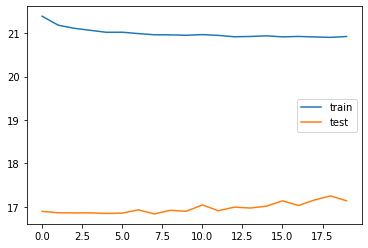

In [161]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [162]:
res = model.predict(X_te_reshaped)

In [163]:
test_data["DL_PRED"] = res
# test_data['DEP_DELAY_SCALED'] = dep_delay_tescaled

In [164]:
np.sqrt(mean_squared_error(test_data.DEP_DELAY,test_data.DL_PRED))

39.00308248637693

In [165]:
# keras_show = TimeSeries(test_data,x="FL_DATE",y=["DEP_DELAY","DL_PRED"],legend=True,plot_width=900, plot_height=350)
# show(keras_show)
sep_30m = test_data[test_data.FL_DATE >= pd.to_datetime("2019-11-29")]
# sep_30m = sep_30m.sort_values(by='FL_DATE',ascending=True)
sep_30m.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DL_PRED
440691,2019-11-29 00:23:00,14107,83,12478,70,00:23:00,00:20:00,-3.0,04:59:00,06:05:00,66.0,0.0,0.0,276.0,345.0,224.0,1.0,2153.0,0,0,0,25.0,94.0,2.0,-9.0,-7.0,6.100016
440692,2019-11-29 00:30:00,12892,57,12478,70,00:30:00,00:21:00,-9.0,05:50:00,05:30:00,-20.0,0.0,0.0,320.0,309.0,284.0,1.0,2475.0,0,0,0,-3.0,25.0,94.0,2.0,-9.0,3.775094
440693,2019-11-29 02:50:00,12265,74,11697,36,02:50:00,02:59:00,9.0,05:49:00,05:47:00,-2.0,0.0,0.0,179.0,168.0,138.0,1.0,1176.0,0,0,1,-9.0,-3.0,25.0,94.0,2.0,2.278283
440694,2019-11-29 02:55:00,14025,85,11697,36,02:55:00,02:50:00,-5.0,06:22:00,06:21:00,-1.0,0.0,0.0,207.0,211.0,160.0,1.0,1334.0,0,0,1,9.0,-9.0,-3.0,25.0,94.0,2.463840
440695,2019-11-29 03:19:00,14254,86,12478,70,03:19:00,03:16:00,-3.0,07:18:00,07:28:00,10.0,0.0,0.0,239.0,252.0,234.0,1.0,1617.0,0,0,0,-5.0,9.0,-9.0,-3.0,25.0,-1.879956


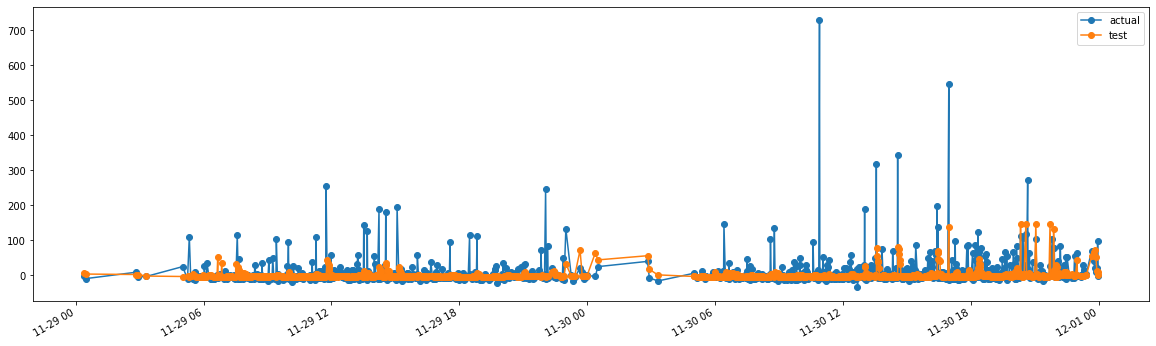

In [166]:
plt.figure(figsize=(20,6))
plt.plot_date(sep_30m['FL_DATE'], sep_30m['DEP_DELAY'], label='actual', linestyle ='solid')
plt.plot_date(sep_30m['FL_DATE'], sep_30m['DL_PRED'], label='test', linestyle ='solid')
plt.gcf().autofmt_xdate()
plt.legend()

In [167]:
p = figure(plot_width=950, plot_height=400, x_axis_type="datetime")

# add a line renderer
p.multi_line([sep_30m['FL_DATE'], sep_30m['FL_DATE']], [sep_30m['DL_PRED'], sep_30m['DEP_DELAY']], 
             color=["blue", "firebrick"], alpha=[0.8, 0.3], line_width=2, legend_label='pred')
# p.line(sep_30m['FL_DATE'], sep_30m['DL_PRED'], line_width=2, legend_label='pred')
# p.line(sep_30m['FL_DATE'], sep_30m['DEP_DELAY'], line_width=2, color='red', legend_label='actual')
p.legend.location = "top_left"
p.legend.click_policy="hide"

show(p)

In [168]:
sep_30m[['DEP_DELAY', 'DL_PRED']].tail(10)

,DEP_DELAY,DL_PRED
391762,16.0,-2.732662
391763,2.0,-0.146119
391764,4.0,0.015822
440816,70.0,54.532757
440817,42.0,67.659485
440818,20.0,73.708221
440819,10.0,52.794174
440820,20.0,12.069030
440821,97.0,8.893907
391765,-2.0,-0.180243
